In [4]:
PATH = "."

# Part 2: Neural Language Modeling (30 pts)


In [5]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


In [6]:
import os
import json
import numpy as np
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from tqdm import tqdm
import math

In [7]:
import gc

gc.collect()

15

## 1 LSTM and Hyper-parameters (10 pts)

In [8]:
def load_wikitext(filename=f'{PATH}/wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

def perplexity(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl

In [9]:
datasets, vocab = load_wikitext()

Vocab size: 33175


### Utilities

In [10]:
class Dictionary(object): #maps words to indices
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('<bos>') #beginning of sentence
        self.add_token('<eos>') #end of sentence
        self.add_token('<pad>')
        self.add_token('<unk>') #unknown. Needed in case use with text with word that isn't in vocab
        
        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
                            
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)

In [11]:
wikitext_dict = Dictionary(datasets, include_valid=True)

100%|██████████| 8464/8464 [00:10<00:00, 776.55it/s]


In [12]:
class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])


In [13]:
#substitute words with numbers. Sometimes can include splitting strings, dealing with punctuation and symbols.

def tokenize_dataset(datasets, dictionary, ngram_order=2):
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets


In [14]:
wikitext_tokenized_datasets = tokenize_dataset(datasets, wikitext_dict)
wikitext_tensor_dataset = dict()

for split, listoflists in wikitext_tokenized_datasets.items():
    wikitext_tensor_dataset[split] = TensoredDataset(listoflists)

100%|██████████| 9708/9708 [00:00<00:00, 41851.73it/s]


In [15]:
def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors])
    padded_list = []
    
    for t in list_of_tensors:
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    return padded_tensor


def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    #pad_token = 2
    pad_token = wikitext_dict.get_id('<pad>')

    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)

    return input_tensor, target_tensor


In [16]:
wikitext_loaders = dict()
batch_size = 128

for split, dataset in wikitext_tensor_dataset.items():
    wikitext_loaders[split] = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)


### Model + Training (5 pts)

#### Model

In [17]:
#RNN is only difference from previous model

class RNNLanguageModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.rnn = nn.LSTM(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['rnn_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        # [batch_size, sen_length]
        embeddings = self.lookup(encoded_input_sequence)
        # [batch_size, sen_length, embed_length]
        rnn_outputs = self.rnn(embeddings)
        # [batch_size, sen_length, state_dim]
        
        #convenient for seq to seq models. check shape of output. lstm gives different
        logits = self.projection(rnn_outputs[0])

        return logits


#### Training

In [18]:
def get_device():
    num_gpus = torch.cuda.device_count()
    return 'cuda' if num_gpus > 0 else 'cpu'


def get_model(options: dict, path: str, load_pretrained: bool = False, device: str = 'cpu'):
    """
    """
    if load_pretrained:
        if not os.path.exists('wikitext_lstm_lm.pt'):
            raise EOFError('Download pretrained model!')
        model_dict = torch.load('wikitext_lstm_lm.pt', map_location=device)

        options = model_dict['options']
        model = RNNLanguageModel(options).to(device)
        model.load_state_dict(model_dict['model_dict'])
        return model

    model = RNNLanguageModel(options).to(device)
    return model


def get_checkpoint(model, optimizer, PATH):
    """
    Run the model by the checkpoint to set "start" of the model.
    """
    if os.path.exists(PATH):
        checkpoint = torch.load(PATH)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        train_losses = checkpoint['train_losses']
        val_losses = checkpoint['val_losses']
        best_val_loss = checkpoint['best_val_loss']
    else:
        epoch = 0
        train_losses = list()
        val_losses = list()
        best_val_loss = math.inf

    return model, optimizer, epoch, train_losses, val_losses, best_val_loss


In [19]:
def train_util(model, train_loader, optimizer, criterion, device):
    
    avg_loss = 0
    model.train()
    train_log_cache = []
    for i, (inp, target) in tqdm(enumerate(train_loader)):
        
        optimizer.zero_grad()
        inp = inp.to(device)
        target = target.to(device)
        logits = model(inp)

        loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
        loss.backward()
        optimizer.step()

        train_log_cache.append(loss.item())

        if i % 100 == 0:
            avg_loss = sum(train_log_cache)/len(train_log_cache)
            print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
            train_log_cache = []
        
    return avg_loss

            
def validation_util(model, val_loader, criterion, epoch, device):
    avg_loss = 0
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in tqdm(enumerate(val_loader)):
            inp = inp.to(device)
            target = target.to(device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())
            
        avg_loss = sum(valid_losses) / len(valid_losses)
        
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch, avg_loss, prec=4))
    return avg_loss


def train(model, train_loader, val_loader, optimizer, criterion, epochs, max_patience, load_pretrained, device, PATH):
    
    model, optimizer, epoch_start, train_losses, val_losses, best_val_loss = get_checkpoint(model, optimizer, PATH)
    patience_remaining = max_patience
    
    for epoch in range(epoch_start, epochs):

        if patience_remaining < 0:
            print("Patience over!")
            break

        if load_pretrained:
            break

        train_loss = train_util(model, train_loader, optimizer, criterion, device)
        val_loss = validation_util(model, val_loader, criterion, epoch, device)
        
        print(f"Epoch {epoch}:\tTrain loss: {train_loss}\tValid loss: {val_loss}")
        
        # save model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # save model checkpoint
            torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'max_patience': max_patience,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'best_val_loss': best_val_loss
            }, f"{PATH}")
            print(f"Model saved for epoch {epoch}")

        # replenish
        if len(val_losses) == 0 or val_losses[-1] > val_loss:
            patience_remaining = max_patience

        # patience reduced
        else:
            patience_remaining -= 1
            print(f"Patience remaining {patience_remaining}")
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
     
    return train_losses, val_losses

#### Performance variation based on hyper-parameter values (5 pts)

##### Common hyperparameters across models

In [20]:
device = get_device()
load_pretrained = False

embedding_size = 256
hidden_size = 512
num_layers = 3
rnn_dropout = 0.3

options = {
    'num_embeddings': len(wikitext_dict),
    'embedding_dim': embedding_size,
    'padding_idx': wikitext_dict.get_id('<pad>'),
    'input_size': embedding_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'rnn_dropout': rnn_dropout,
}
epochs = 20
criterion = nn.CrossEntropyLoss(ignore_index=wikitext_dict.get_id('<pad>'))

##### Training config - 1

In [21]:
train_loader1 = wikitext_loaders['train']
val_loader1 = wikitext_loaders['valid']

max_patience1 = 0
model_path1 = f"{PATH}/results/part2/models/max_patience_{max_patience1}.pt"

model1 = get_model(options, model_path1, load_pretrained, device)
model_parameters1 = [p for p in model1.parameters() if p.requires_grad]
optimizer1 = optim.Adam(model_parameters1, lr=0.001)

train_losses1, val_losses1 = train(model1,
                                 train_loader1,
                                 val_loader1,
                                 optimizer1,
                                 criterion,
                                 epochs,
                                 max_patience1,
                                 load_pretrained,
                                 device,
                                 model_path1)


2it [00:03,  1.30s/it]

Step 0 avg train loss = 10.4120


102it [00:16,  5.92it/s]

Step 100 avg train loss = 7.4013


202it [00:30,  7.99it/s]

Step 200 avg train loss = 7.0380


302it [00:43,  7.34it/s]

Step 300 avg train loss = 6.9833


402it [00:56,  7.94it/s]

Step 400 avg train loss = 6.9465


502it [01:10,  6.98it/s]

Step 500 avg train loss = 6.7837


602it [01:23,  7.49it/s]

Step 600 avg train loss = 6.5850


612it [01:25,  7.19it/s]
67it [00:03, 21.17it/s]


Validation loss after 0 epoch = 6.3325
Epoch 0:	Train loss: 6.584974670410157	Valid loss: 6.332461357116699
Model saved for epoch 0


1it [00:00,  6.24it/s]

Step 0 avg train loss = 6.4637


102it [00:13,  7.62it/s]

Step 100 avg train loss = 6.4296


202it [00:27,  7.32it/s]

Step 200 avg train loss = 6.3451


302it [00:41,  7.41it/s]

Step 300 avg train loss = 6.2560


402it [00:54,  7.03it/s]

Step 400 avg train loss = 6.1625


502it [01:08,  7.23it/s]

Step 500 avg train loss = 6.0885


602it [01:21,  7.65it/s]

Step 600 avg train loss = 6.0064


612it [01:22,  7.40it/s]
67it [00:03, 21.06it/s]


Validation loss after 1 epoch = 5.8208
Epoch 1:	Train loss: 6.006431188583374	Valid loss: 5.820801492947251
Model saved for epoch 1


1it [00:00,  5.95it/s]

Step 0 avg train loss = 5.8674


102it [00:13,  7.20it/s]

Step 100 avg train loss = 5.8683


202it [00:27,  7.64it/s]

Step 200 avg train loss = 5.8275


302it [00:40,  7.91it/s]

Step 300 avg train loss = 5.7839


402it [00:53,  7.88it/s]

Step 400 avg train loss = 5.7217


502it [01:07,  7.62it/s]

Step 500 avg train loss = 5.6997


602it [01:21,  7.63it/s]

Step 600 avg train loss = 5.6432


612it [01:22,  7.43it/s]
67it [00:03, 22.04it/s]


Validation loss after 2 epoch = 5.5226
Epoch 2:	Train loss: 5.643217177391052	Valid loss: 5.522560518179366
Model saved for epoch 2


1it [00:00,  7.05it/s]

Step 0 avg train loss = 5.4851


102it [00:13,  7.07it/s]

Step 100 avg train loss = 5.5235


202it [00:27,  7.04it/s]

Step 200 avg train loss = 5.4844


302it [00:40,  7.44it/s]

Step 300 avg train loss = 5.4702


402it [00:54,  8.08it/s]

Step 400 avg train loss = 5.4393


502it [01:07,  7.98it/s]

Step 500 avg train loss = 5.4196


602it [01:21,  7.27it/s]

Step 600 avg train loss = 5.3911


612it [01:22,  7.44it/s]
67it [00:03, 20.62it/s]


Validation loss after 3 epoch = 5.3568
Epoch 3:	Train loss: 5.391084189414978	Valid loss: 5.3568214871990145
Model saved for epoch 3


1it [00:00,  5.36it/s]

Step 0 avg train loss = 5.2984


102it [00:13,  7.73it/s]

Step 100 avg train loss = 5.2418


202it [00:27,  8.13it/s]

Step 200 avg train loss = 5.2487


302it [00:40,  7.66it/s]

Step 300 avg train loss = 5.2245


402it [00:53,  7.03it/s]

Step 400 avg train loss = 5.2177


502it [01:07,  7.30it/s]

Step 500 avg train loss = 5.1994


602it [01:21,  6.89it/s]

Step 600 avg train loss = 5.1908


612it [01:22,  7.40it/s]
67it [00:03, 20.94it/s]


Validation loss after 4 epoch = 5.2554
Epoch 4:	Train loss: 5.190804839134216	Valid loss: 5.255386929013836
Model saved for epoch 4


1it [00:00,  8.30it/s]

Step 0 avg train loss = 5.0739


102it [00:13,  6.95it/s]

Step 100 avg train loss = 5.0415


202it [00:27,  7.55it/s]

Step 200 avg train loss = 5.0386


302it [00:40,  6.58it/s]

Step 300 avg train loss = 5.0437


402it [00:54,  7.65it/s]

Step 400 avg train loss = 5.0241


502it [01:07,  7.80it/s]

Step 500 avg train loss = 5.0226


602it [01:21,  6.73it/s]

Step 600 avg train loss = 5.0111


612it [01:22,  7.41it/s]
67it [00:03, 21.33it/s]


Validation loss after 5 epoch = 5.1937
Epoch 5:	Train loss: 5.011114535331726	Valid loss: 5.1937071743296155
Model saved for epoch 5


1it [00:00,  6.22it/s]

Step 0 avg train loss = 4.8734


102it [00:13,  7.59it/s]

Step 100 avg train loss = 4.8726


202it [00:27,  6.58it/s]

Step 200 avg train loss = 4.8652


302it [00:40,  7.23it/s]

Step 300 avg train loss = 4.8735


402it [00:54,  7.22it/s]

Step 400 avg train loss = 4.8671


502it [01:07,  8.13it/s]

Step 500 avg train loss = 4.8706


602it [01:21,  7.48it/s]

Step 600 avg train loss = 4.8579


612it [01:22,  7.42it/s]
67it [00:03, 20.63it/s]


Validation loss after 6 epoch = 5.1573
Epoch 6:	Train loss: 4.8578564119338985	Valid loss: 5.157289974725068
Model saved for epoch 6


1it [00:00,  6.75it/s]

Step 0 avg train loss = 4.6410


102it [00:13,  6.96it/s]

Step 100 avg train loss = 4.7052


202it [00:27,  7.31it/s]

Step 200 avg train loss = 4.7243


302it [00:40,  7.30it/s]

Step 300 avg train loss = 4.7160


402it [00:54,  8.10it/s]

Step 400 avg train loss = 4.7216


502it [01:07,  7.18it/s]

Step 500 avg train loss = 4.7267


602it [01:21,  7.23it/s]

Step 600 avg train loss = 4.7378


612it [01:22,  7.42it/s]
67it [00:03, 21.02it/s]


Validation loss after 7 epoch = 5.1267
Epoch 7:	Train loss: 4.737826218605042	Valid loss: 5.126747138464629
Model saved for epoch 7


1it [00:00,  6.35it/s]

Step 0 avg train loss = 4.6674


102it [00:13,  8.28it/s]

Step 100 avg train loss = 4.5656


202it [00:27,  7.14it/s]

Step 200 avg train loss = 4.5836


302it [00:41,  7.65it/s]

Step 300 avg train loss = 4.5870


402it [00:54,  7.90it/s]

Step 400 avg train loss = 4.6014


502it [01:07,  7.49it/s]

Step 500 avg train loss = 4.6016


602it [01:21,  7.25it/s]

Step 600 avg train loss = 4.5880


612it [01:23,  7.35it/s]
67it [00:03, 21.29it/s]

Validation loss after 8 epoch = 5.1317
Epoch 8:	Train loss: 4.5880050945281985	Valid loss: 5.131745516364254
Patience remaining -1
Patience over!


##### Train config 2

In [22]:
train_loader2 = wikitext_loaders['train']
val_loader2 = wikitext_loaders['valid']

max_patience2 = 2
model_path2 = f"{PATH}/results/part2/models/max_patience_{max_patience2}.pt"

model2 = get_model(options, model_path2, load_pretrained, device)
model_parameters2 = [p for p in model2.parameters() if p.requires_grad]
optimizer2 = optim.Adam(model_parameters2, lr=0.001)

train_losses2, val_losses2 = train(model2,
                                 train_loader2,
                                 val_loader2,
                                 optimizer2,
                                 criterion,
                                 epochs,
                                 max_patience2,
                                 load_pretrained,
                                 device,
                                 model_path2)


2it [00:00,  7.46it/s]

Step 0 avg train loss = 10.4080


102it [00:13,  7.33it/s]

Step 100 avg train loss = 7.4046


202it [00:27,  7.14it/s]

Step 200 avg train loss = 7.0223


302it [00:40,  7.57it/s]

Step 300 avg train loss = 6.9712


402it [00:53,  7.22it/s]

Step 400 avg train loss = 6.8636


502it [01:07,  7.48it/s]

Step 500 avg train loss = 6.6272


602it [01:21,  7.28it/s]

Step 600 avg train loss = 6.5002


612it [01:22,  7.39it/s]
67it [00:03, 21.45it/s]


Validation loss after 0 epoch = 6.2420
Epoch 0:	Train loss: 6.500224018096924	Valid loss: 6.242024884295108
Model saved for epoch 0


2it [00:00,  4.71it/s]

Step 0 avg train loss = 6.3790


102it [00:13,  7.46it/s]

Step 100 avg train loss = 6.3455


202it [00:27,  7.47it/s]

Step 200 avg train loss = 6.2711


302it [00:41,  7.14it/s]

Step 300 avg train loss = 6.2005


402it [00:55,  7.63it/s]

Step 400 avg train loss = 6.1135


502it [01:09,  7.49it/s]

Step 500 avg train loss = 6.0317


602it [01:22,  7.95it/s]

Step 600 avg train loss = 5.9693


612it [01:24,  7.27it/s]
67it [00:03, 21.34it/s]


Validation loss after 1 epoch = 5.7916
Epoch 1:	Train loss: 5.969329357147217	Valid loss: 5.7915528354360095
Model saved for epoch 1


1it [00:00,  8.33it/s]

Step 0 avg train loss = 5.9048


102it [00:13,  7.30it/s]

Step 100 avg train loss = 5.8413


202it [00:27,  7.33it/s]

Step 200 avg train loss = 5.7878


302it [00:41,  7.53it/s]

Step 300 avg train loss = 5.7487


402it [00:55,  7.42it/s]

Step 400 avg train loss = 5.7029


502it [01:09,  7.21it/s]

Step 500 avg train loss = 5.6663


602it [01:23,  6.84it/s]

Step 600 avg train loss = 5.6238


612it [01:24,  7.23it/s]
67it [00:03, 21.32it/s]


Validation loss after 2 epoch = 5.5043
Epoch 2:	Train loss: 5.623814635276794	Valid loss: 5.504285847962792
Model saved for epoch 2


1it [00:00,  6.75it/s]

Step 0 avg train loss = 5.5498


102it [00:14,  7.30it/s]

Step 100 avg train loss = 5.4846


202it [00:28,  7.01it/s]

Step 200 avg train loss = 5.4730


302it [00:42,  6.76it/s]

Step 300 avg train loss = 5.4318


402it [00:55,  7.50it/s]

Step 400 avg train loss = 5.4149


502it [01:09,  7.26it/s]

Step 500 avg train loss = 5.3992


602it [01:23,  7.12it/s]

Step 600 avg train loss = 5.3761


612it [01:25,  7.20it/s]
67it [00:03, 21.45it/s]


Validation loss after 3 epoch = 5.3516
Epoch 3:	Train loss: 5.376132183074951	Valid loss: 5.351561162009168
Model saved for epoch 3


1it [00:00,  8.61it/s]

Step 0 avg train loss = 5.1613


102it [00:14,  7.26it/s]

Step 100 avg train loss = 5.2283


202it [00:28,  7.26it/s]

Step 200 avg train loss = 5.2218


302it [00:41,  6.94it/s]

Step 300 avg train loss = 5.2097


402it [00:55,  7.70it/s]

Step 400 avg train loss = 5.1888


502it [01:09,  8.14it/s]

Step 500 avg train loss = 5.1766


602it [01:23,  7.38it/s]

Step 600 avg train loss = 5.1564


612it [01:25,  7.18it/s]
67it [00:03, 21.85it/s]


Validation loss after 4 epoch = 5.2588
Epoch 4:	Train loss: 5.156384410858155	Valid loss: 5.258756345777369
Model saved for epoch 4


1it [00:00,  6.94it/s]

Step 0 avg train loss = 4.9974


102it [00:13,  6.88it/s]

Step 100 avg train loss = 5.0144


202it [00:27,  7.36it/s]

Step 200 avg train loss = 5.0119


302it [00:42,  7.03it/s]

Step 300 avg train loss = 5.0044


402it [00:55,  7.70it/s]

Step 400 avg train loss = 5.0137


502it [01:09,  7.23it/s]

Step 500 avg train loss = 4.9945


602it [01:23,  7.67it/s]

Step 600 avg train loss = 4.9902


612it [01:24,  7.21it/s]
67it [00:03, 21.65it/s]


Validation loss after 5 epoch = 5.2014
Epoch 5:	Train loss: 4.990203957557679	Valid loss: 5.2013733920766345
Model saved for epoch 5


1it [00:00,  7.77it/s]

Step 0 avg train loss = 4.8188


102it [00:14,  7.10it/s]

Step 100 avg train loss = 4.8255


202it [00:28,  7.19it/s]

Step 200 avg train loss = 4.8454


302it [00:42,  7.24it/s]

Step 300 avg train loss = 4.8409


402it [00:56,  7.38it/s]

Step 400 avg train loss = 4.8471


502it [01:10,  7.05it/s]

Step 500 avg train loss = 4.8422


602it [01:23,  7.27it/s]

Step 600 avg train loss = 4.8470


612it [01:25,  7.17it/s]
67it [00:03, 21.88it/s]


Validation loss after 6 epoch = 5.1707
Epoch 6:	Train loss: 4.847002849578858	Valid loss: 5.1707238368134
Model saved for epoch 6


1it [00:00,  8.99it/s]

Step 0 avg train loss = 4.6699


102it [00:14,  7.95it/s]

Step 100 avg train loss = 4.6781


202it [00:28,  7.07it/s]

Step 200 avg train loss = 4.7014


302it [00:41,  7.07it/s]

Step 300 avg train loss = 4.7054


402it [00:55,  7.31it/s]

Step 400 avg train loss = 4.6930


502it [01:09,  6.94it/s]

Step 500 avg train loss = 4.7062


602it [01:23,  7.21it/s]

Step 600 avg train loss = 4.7007


612it [01:24,  7.22it/s]
67it [00:03, 21.36it/s]


Validation loss after 7 epoch = 5.1609
Epoch 7:	Train loss: 4.7006527614593505	Valid loss: 5.160923053969198
Model saved for epoch 7


1it [00:00,  6.76it/s]

Step 0 avg train loss = 4.5357


102it [00:14,  6.80it/s]

Step 100 avg train loss = 4.5362


202it [00:27,  7.70it/s]

Step 200 avg train loss = 4.5609


302it [00:41,  7.98it/s]

Step 300 avg train loss = 4.5671


402it [00:54,  7.37it/s]

Step 400 avg train loss = 4.5790


502it [01:08,  6.84it/s]

Step 500 avg train loss = 4.5764


602it [01:22,  8.29it/s]

Step 600 avg train loss = 4.5871


612it [01:23,  7.35it/s]
67it [00:03, 21.94it/s]


Validation loss after 8 epoch = 5.1640
Epoch 8:	Train loss: 4.587144370079041	Valid loss: 5.164035953692536
Patience remaining 1


1it [00:00,  7.92it/s]

Step 0 avg train loss = 4.4187


102it [00:13,  8.29it/s]

Step 100 avg train loss = 4.4052


202it [00:27,  8.03it/s]

Step 200 avg train loss = 4.4393


302it [00:40,  7.38it/s]

Step 300 avg train loss = 4.4466


402it [00:54,  7.19it/s]

Step 400 avg train loss = 4.4690


502it [01:08,  7.12it/s]

Step 500 avg train loss = 4.4637


602it [01:21,  7.63it/s]

Step 600 avg train loss = 4.4719


612it [01:22,  7.39it/s]
67it [00:03, 20.72it/s]


Validation loss after 9 epoch = 5.1664
Epoch 9:	Train loss: 4.471870112419128	Valid loss: 5.16635479144196
Patience remaining 0


1it [00:00,  7.89it/s]

Step 0 avg train loss = 4.3666


102it [00:14,  7.46it/s]

Step 100 avg train loss = 4.3038


202it [00:27,  7.57it/s]

Step 200 avg train loss = 4.3286


302it [00:41,  7.91it/s]

Step 300 avg train loss = 4.3338


402it [00:54,  7.66it/s]

Step 400 avg train loss = 4.3562


502it [01:08,  6.45it/s]

Step 500 avg train loss = 4.3492


602it [01:21,  7.61it/s]

Step 600 avg train loss = 4.3691


612it [01:22,  7.40it/s]
67it [00:03, 21.59it/s]

Validation loss after 10 epoch = 5.1830
Epoch 10:	Train loss: 4.369100365638733	Valid loss: 5.182959492526837
Patience remaining -1
Patience over!


##### Train config 3

In [23]:
train_loader3 = wikitext_loaders['train']
val_loader3 = wikitext_loaders['valid']

max_patience3 = 4
model_path3 = f"{PATH}/results/part2/models/max_patience_{max_patience3}.pt"

model3 = get_model(options, model_path3, load_pretrained, device)
model_parameters3 = [p for p in model3.parameters() if p.requires_grad]
optimizer3 = optim.Adam(model_parameters3, lr=0.001)

train_losses3, val_losses3 = train(model3,
                                 train_loader3,
                                 val_loader3,
                                 optimizer3,
                                 criterion,
                                 epochs,
                                 max_patience3,
                                 load_pretrained,
                                 device,
                                 model_path3)


2it [00:00,  7.50it/s]

Step 0 avg train loss = 10.4100


101it [00:13,  7.64it/s]

Step 100 avg train loss = 7.3994


202it [00:27,  7.10it/s]

Step 200 avg train loss = 7.0227


302it [00:41,  6.97it/s]

Step 300 avg train loss = 6.9800


402it [00:54,  6.59it/s]

Step 400 avg train loss = 6.9403


502it [01:08,  7.72it/s]

Step 500 avg train loss = 6.7636


602it [01:21,  7.84it/s]

Step 600 avg train loss = 6.5488


612it [01:22,  7.41it/s]
67it [00:03, 21.49it/s]


Validation loss after 0 epoch = 6.2809
Epoch 0:	Train loss: 6.548811826705933	Valid loss: 6.280874650869796
Model saved for epoch 0


1it [00:00,  7.66it/s]

Step 0 avg train loss = 6.3922


102it [00:13,  6.87it/s]

Step 100 avg train loss = 6.3823


202it [00:27,  7.95it/s]

Step 200 avg train loss = 6.3029


302it [00:40,  7.77it/s]

Step 300 avg train loss = 6.2149


402it [00:54,  6.55it/s]

Step 400 avg train loss = 6.1244


502it [01:07,  6.90it/s]

Step 500 avg train loss = 6.0389


602it [01:21,  7.44it/s]

Step 600 avg train loss = 5.9645


612it [01:22,  7.39it/s]
67it [00:03, 21.96it/s]


Validation loss after 1 epoch = 5.7786
Epoch 1:	Train loss: 5.964521427154541	Valid loss: 5.778638633329477
Model saved for epoch 1


1it [00:00,  8.06it/s]

Step 0 avg train loss = 5.9193


102it [00:13,  6.59it/s]

Step 100 avg train loss = 5.8336


202it [00:27,  7.01it/s]

Step 200 avg train loss = 5.7890


302it [00:40,  7.06it/s]

Step 300 avg train loss = 5.7497


402it [00:54,  7.14it/s]

Step 400 avg train loss = 5.7034


502it [01:08,  8.21it/s]

Step 500 avg train loss = 5.6584


602it [01:21,  8.02it/s]

Step 600 avg train loss = 5.6202


612it [01:23,  7.36it/s]
67it [00:03, 21.81it/s]


Validation loss after 2 epoch = 5.5015
Epoch 2:	Train loss: 5.620187401771545	Valid loss: 5.501524384342023
Model saved for epoch 2


1it [00:00,  6.08it/s]

Step 0 avg train loss = 5.5138


102it [00:13,  7.34it/s]

Step 100 avg train loss = 5.4894


202it [00:27,  8.34it/s]

Step 200 avg train loss = 5.4674


302it [00:40,  7.18it/s]

Step 300 avg train loss = 5.4419


402it [00:54,  7.42it/s]

Step 400 avg train loss = 5.4109


502it [01:08,  7.84it/s]

Step 500 avg train loss = 5.3936


602it [01:22,  7.37it/s]

Step 600 avg train loss = 5.3742


612it [01:23,  7.35it/s]
67it [00:03, 20.08it/s]


Validation loss after 3 epoch = 5.3478
Epoch 3:	Train loss: 5.374233989715576	Valid loss: 5.347824594867763
Model saved for epoch 3


1it [00:00,  7.39it/s]

Step 0 avg train loss = 5.3051


102it [00:14,  6.70it/s]

Step 100 avg train loss = 5.2371


202it [00:27,  6.59it/s]

Step 200 avg train loss = 5.2091


302it [00:41,  6.86it/s]

Step 300 avg train loss = 5.1928


402it [00:55,  7.36it/s]

Step 400 avg train loss = 5.1921


502it [01:08,  7.09it/s]

Step 500 avg train loss = 5.1767


602it [01:21,  7.07it/s]

Step 600 avg train loss = 5.1623


612it [01:23,  7.34it/s]
67it [00:03, 21.14it/s]


Validation loss after 4 epoch = 5.2441
Epoch 4:	Train loss: 5.162280688285827	Valid loss: 5.244123487330195
Model saved for epoch 4


1it [00:00,  6.45it/s]

Step 0 avg train loss = 4.8957


102it [00:13,  7.31it/s]

Step 100 avg train loss = 5.0094


202it [00:27,  7.61it/s]

Step 200 avg train loss = 5.0099


302it [00:41,  7.12it/s]

Step 300 avg train loss = 5.0049


402it [00:54,  7.13it/s]

Step 400 avg train loss = 5.0028


502it [01:07,  7.94it/s]

Step 500 avg train loss = 4.9880


602it [01:21,  7.87it/s]

Step 600 avg train loss = 4.9899


612it [01:22,  7.43it/s]
67it [00:03, 20.71it/s]


Validation loss after 5 epoch = 5.1843
Epoch 5:	Train loss: 4.989879236221314	Valid loss: 5.184333459654851
Model saved for epoch 5


1it [00:00,  8.15it/s]

Step 0 avg train loss = 4.9334


102it [00:13,  7.83it/s]

Step 100 avg train loss = 4.8274


202it [00:27,  6.89it/s]

Step 200 avg train loss = 4.8320


301it [00:40,  7.32it/s]

Step 300 avg train loss = 4.8364


402it [00:54,  7.53it/s]

Step 400 avg train loss = 4.8360


502it [01:08,  7.57it/s]

Step 500 avg train loss = 4.8314


602it [01:21,  7.84it/s]

Step 600 avg train loss = 4.8350


612it [01:22,  7.39it/s]
67it [00:03, 20.45it/s]


Validation loss after 6 epoch = 5.1484
Epoch 6:	Train loss: 4.835016732215881	Valid loss: 5.1483555907633765
Model saved for epoch 6


1it [00:00,  7.00it/s]

Step 0 avg train loss = 4.7404


102it [00:13,  7.84it/s]

Step 100 avg train loss = 4.6632


202it [00:26,  8.17it/s]

Step 200 avg train loss = 4.6844


302it [00:40,  7.91it/s]

Step 300 avg train loss = 4.6851


402it [00:54,  7.01it/s]

Step 400 avg train loss = 4.6959


502it [01:07,  7.76it/s]

Step 500 avg train loss = 4.6981


602it [01:21,  7.50it/s]

Step 600 avg train loss = 4.6799


612it [01:22,  7.38it/s]
67it [00:03, 21.47it/s]


Validation loss after 7 epoch = 5.1381
Epoch 7:	Train loss: 4.679871129989624	Valid loss: 5.138125198990552
Model saved for epoch 7


1it [00:00,  5.84it/s]

Step 0 avg train loss = 4.5577


102it [00:14,  7.82it/s]

Step 100 avg train loss = 4.5360


202it [00:27,  6.86it/s]

Step 200 avg train loss = 4.5472


302it [00:41,  7.72it/s]

Step 300 avg train loss = 4.5463


402it [00:54,  7.25it/s]

Step 400 avg train loss = 4.5556


502it [01:08,  7.46it/s]

Step 500 avg train loss = 4.5525


602it [01:22,  7.60it/s]

Step 600 avg train loss = 4.5629


612it [01:23,  7.31it/s]
67it [00:03, 21.88it/s]


Validation loss after 8 epoch = 5.1326
Epoch 8:	Train loss: 4.562943043708802	Valid loss: 5.132569505207575
Model saved for epoch 8


1it [00:00,  5.57it/s]

Step 0 avg train loss = 4.3484


102it [00:14,  7.10it/s]

Step 100 avg train loss = 4.3970


202it [00:28,  6.69it/s]

Step 200 avg train loss = 4.4137


302it [00:42,  7.66it/s]

Step 300 avg train loss = 4.4234


402it [00:56,  7.30it/s]

Step 400 avg train loss = 4.4335


502it [01:10,  7.60it/s]

Step 500 avg train loss = 4.4393


602it [01:23,  7.16it/s]

Step 600 avg train loss = 4.4543


612it [01:25,  7.17it/s]
67it [00:02, 22.43it/s]


Validation loss after 9 epoch = 5.1428
Epoch 9:	Train loss: 4.454340181350708	Valid loss: 5.142783826856471
Patience remaining 3


1it [00:00,  7.28it/s]

Step 0 avg train loss = 4.2572


102it [00:14,  6.85it/s]

Step 100 avg train loss = 4.2707


202it [00:28,  7.74it/s]

Step 200 avg train loss = 4.3047


302it [00:41,  6.79it/s]

Step 300 avg train loss = 4.3160


402it [00:55,  7.79it/s]

Step 400 avg train loss = 4.3208


502it [01:10,  7.50it/s]

Step 500 avg train loss = 4.3422


602it [01:23,  8.28it/s]

Step 600 avg train loss = 4.3315


612it [01:25,  7.18it/s]
67it [00:03, 21.93it/s]


Validation loss after 10 epoch = 5.1646
Epoch 10:	Train loss: 4.331488637924195	Valid loss: 5.164602165791526
Patience remaining 2


1it [00:00,  8.46it/s]

Step 0 avg train loss = 4.1978


102it [00:14,  7.46it/s]

Step 100 avg train loss = 4.1694


202it [00:28,  7.41it/s]

Step 200 avg train loss = 4.1952


302it [00:42,  7.28it/s]

Step 300 avg train loss = 4.2153


402it [00:56,  7.52it/s]

Step 400 avg train loss = 4.2209


502it [01:09,  7.15it/s]

Step 500 avg train loss = 4.2335


602it [01:23,  7.80it/s]

Step 600 avg train loss = 4.2351


612it [01:24,  7.24it/s]
67it [00:03, 21.92it/s]


Validation loss after 11 epoch = 5.1838
Epoch 11:	Train loss: 4.235091590881348	Valid loss: 5.1838215002373085
Patience remaining 1


1it [00:00,  6.60it/s]

Step 0 avg train loss = 4.0619


102it [00:13,  7.95it/s]

Step 100 avg train loss = 4.0690


202it [00:27,  7.59it/s]

Step 200 avg train loss = 4.0967


302it [00:41,  7.39it/s]

Step 300 avg train loss = 4.1136


402it [00:54,  7.75it/s]

Step 400 avg train loss = 4.1284


502it [01:07,  7.25it/s]

Step 500 avg train loss = 4.1370


602it [01:21,  8.12it/s]

Step 600 avg train loss = 4.1578


612it [01:22,  7.40it/s]
67it [00:03, 21.14it/s]


Validation loss after 12 epoch = 5.2201
Epoch 12:	Train loss: 4.157830545902252	Valid loss: 5.220076603675956
Patience remaining 0


1it [00:00,  5.12it/s]

Step 0 avg train loss = 3.9525


102it [00:13,  7.80it/s]

Step 100 avg train loss = 3.9770


202it [00:26,  7.54it/s]

Step 200 avg train loss = 4.0082


302it [00:40,  6.75it/s]

Step 300 avg train loss = 4.0365


402it [00:53,  7.42it/s]

Step 400 avg train loss = 4.0335


502it [01:07,  7.61it/s]

Step 500 avg train loss = 4.0575


602it [01:20,  7.41it/s]

Step 600 avg train loss = 4.0652


612it [01:22,  7.43it/s]
67it [00:03, 20.79it/s]

Validation loss after 13 epoch = 5.2451
Epoch 13:	Train loss: 4.0652014350891115	Valid loss: 5.245107572470138
Patience remaining -1
Patience over!


##### Train config 4

In [24]:
train_loader4 = wikitext_loaders['train']
val_loader4 = wikitext_loaders['valid']

max_patience4 = 6
model_path4 = f"{PATH}/results/part2/models/max_patience_{max_patience4}.pt"

model4 = get_model(options, model_path4, load_pretrained, device)
model_parameters4 = [p for p in model4.parameters() if p.requires_grad]
optimizer4 = optim.Adam(model_parameters4, lr=0.001)

train_losses4, val_losses4 = train(model4,
                                 train_loader4,
                                 val_loader4,
                                 optimizer4,
                                 criterion,
                                 epochs,
                                 max_patience4,
                                 load_pretrained,
                                 device,
                                 model_path4)


1it [00:00,  4.64it/s]

Step 0 avg train loss = 10.4050


102it [00:13,  7.02it/s]

Step 100 avg train loss = 7.3957


202it [00:27,  7.74it/s]

Step 200 avg train loss = 7.0282


302it [00:41,  7.75it/s]

Step 300 avg train loss = 6.9852


402it [00:55,  6.92it/s]

Step 400 avg train loss = 6.9403


502it [01:08,  7.62it/s]

Step 500 avg train loss = 6.7896


602it [01:21,  7.76it/s]

Step 600 avg train loss = 6.5537


612it [01:22,  7.38it/s]
67it [00:03, 20.64it/s]


Validation loss after 0 epoch = 6.2772
Epoch 0:	Train loss: 6.553728990554809	Valid loss: 6.277169462460191
Model saved for epoch 0


1it [00:00,  6.40it/s]

Step 0 avg train loss = 6.3706


102it [00:13,  7.98it/s]

Step 100 avg train loss = 6.3684


202it [00:26,  8.19it/s]

Step 200 avg train loss = 6.2753


302it [00:40,  7.69it/s]

Step 300 avg train loss = 6.1713


402it [00:53,  7.15it/s]

Step 400 avg train loss = 6.0951


502it [01:07,  7.36it/s]

Step 500 avg train loss = 6.0058


602it [01:21,  7.19it/s]

Step 600 avg train loss = 5.9296


612it [01:22,  7.40it/s]
67it [00:03, 21.72it/s]


Validation loss after 1 epoch = 5.7395
Epoch 1:	Train loss: 5.929616370201111	Valid loss: 5.739450148682096
Model saved for epoch 1


1it [00:00,  7.79it/s]

Step 0 avg train loss = 5.7725


102it [00:13,  7.06it/s]

Step 100 avg train loss = 5.7890


202it [00:27,  7.64it/s]

Step 200 avg train loss = 5.7438


302it [00:40,  7.58it/s]

Step 300 avg train loss = 5.7070


402it [00:54,  7.06it/s]

Step 400 avg train loss = 5.6622


502it [01:08,  6.59it/s]

Step 500 avg train loss = 5.6019


602it [01:21,  7.57it/s]

Step 600 avg train loss = 5.5825


612it [01:22,  7.40it/s]
67it [00:03, 21.52it/s]


Validation loss after 2 epoch = 5.4699
Epoch 2:	Train loss: 5.582544937133789	Valid loss: 5.469945665615708
Model saved for epoch 2


1it [00:00,  5.18it/s]

Step 0 avg train loss = 5.4297


102it [00:14,  6.76it/s]

Step 100 avg train loss = 5.4529


200it [00:27,  7.88it/s]

Step 200 avg train loss = 5.4166


302it [00:40,  7.66it/s]

Step 300 avg train loss = 5.3983


402it [00:54,  7.76it/s]

Step 400 avg train loss = 5.3785


502it [01:08,  8.45it/s]

Step 500 avg train loss = 5.3562


602it [01:21,  7.44it/s]

Step 600 avg train loss = 5.3354


612it [01:22,  7.39it/s]
67it [00:03, 21.23it/s]


Validation loss after 3 epoch = 5.3272
Epoch 3:	Train loss: 5.335419816970825	Valid loss: 5.327222069697593
Model saved for epoch 3


2it [00:00,  6.62it/s]

Step 0 avg train loss = 5.2761


102it [00:14,  7.74it/s]

Step 100 avg train loss = 5.2031


202it [00:27,  7.79it/s]

Step 200 avg train loss = 5.1767


302it [00:40,  7.68it/s]

Step 300 avg train loss = 5.1777


402it [00:54,  7.08it/s]

Step 400 avg train loss = 5.1600


502it [01:08,  7.79it/s]

Step 500 avg train loss = 5.1509


602it [01:21,  7.83it/s]

Step 600 avg train loss = 5.1281


612it [01:22,  7.38it/s]
67it [00:03, 22.13it/s]


Validation loss after 4 epoch = 5.2394
Epoch 4:	Train loss: 5.128072385787964	Valid loss: 5.239434356120095
Model saved for epoch 4


1it [00:00,  7.70it/s]

Step 0 avg train loss = 4.9675


102it [00:13,  6.77it/s]

Step 100 avg train loss = 4.9880


202it [00:27,  6.90it/s]

Step 200 avg train loss = 4.9935


302it [00:40,  7.84it/s]

Step 300 avg train loss = 4.9905


402it [00:53,  7.59it/s]

Step 400 avg train loss = 4.9945


502it [01:07,  7.02it/s]

Step 500 avg train loss = 4.9831


602it [01:20,  7.94it/s]

Step 600 avg train loss = 4.9692


612it [01:22,  7.45it/s]
67it [00:03, 21.16it/s]


Validation loss after 5 epoch = 5.1877
Epoch 5:	Train loss: 4.969242601394654	Valid loss: 5.187728006448319
Model saved for epoch 5


1it [00:00,  6.78it/s]

Step 0 avg train loss = 4.8150


102it [00:14,  7.26it/s]

Step 100 avg train loss = 4.8163


202it [00:27,  7.10it/s]

Step 200 avg train loss = 4.8330


302it [00:40,  7.52it/s]

Step 300 avg train loss = 4.8323


402it [00:54,  7.88it/s]

Step 400 avg train loss = 4.8354


502it [01:07,  6.82it/s]

Step 500 avg train loss = 4.8300


602it [01:21,  7.45it/s]

Step 600 avg train loss = 4.8260


612it [01:22,  7.39it/s]
67it [00:03, 21.54it/s]


Validation loss after 6 epoch = 5.1500
Epoch 6:	Train loss: 4.825950255393982	Valid loss: 5.1500460567759045
Model saved for epoch 6


2it [00:00,  5.72it/s]

Step 0 avg train loss = 4.6710


102it [00:13,  7.11it/s]

Step 100 avg train loss = 4.6592


202it [00:27,  7.15it/s]

Step 200 avg train loss = 4.6897


302it [00:40,  6.79it/s]

Step 300 avg train loss = 4.6821


402it [00:54,  7.08it/s]

Step 400 avg train loss = 4.7066


502it [01:07,  7.70it/s]

Step 500 avg train loss = 4.6961


602it [01:21,  6.81it/s]

Step 600 avg train loss = 4.6899


612it [01:22,  7.38it/s]
67it [00:03, 20.70it/s]


Validation loss after 7 epoch = 5.1312
Epoch 7:	Train loss: 4.689854226112366	Valid loss: 5.13122246870354
Model saved for epoch 7


2it [00:00,  6.35it/s]

Step 0 avg train loss = 4.5526


102it [00:14,  7.07it/s]

Step 100 avg train loss = 4.5287


202it [00:27,  7.58it/s]

Step 200 avg train loss = 4.5519


302it [00:40,  7.71it/s]

Step 300 avg train loss = 4.5609


402it [00:54,  7.85it/s]

Step 400 avg train loss = 4.5652


502it [01:07,  8.18it/s]

Step 500 avg train loss = 4.5688


602it [01:21,  7.30it/s]

Step 600 avg train loss = 4.5572


612it [01:22,  7.38it/s]
67it [00:03, 21.03it/s]


Validation loss after 8 epoch = 5.1344
Epoch 8:	Train loss: 4.557197504043579	Valid loss: 5.1344352195512
Patience remaining 5


1it [00:00,  7.00it/s]

Step 0 avg train loss = 4.3574


102it [00:13,  7.55it/s]

Step 100 avg train loss = 4.4053


202it [00:28,  6.83it/s]

Step 200 avg train loss = 4.4356


302it [00:41,  7.64it/s]

Step 300 avg train loss = 4.4201


402it [00:55,  7.22it/s]

Step 400 avg train loss = 4.4457


502it [01:09,  7.44it/s]

Step 500 avg train loss = 4.4543


602it [01:23,  7.73it/s]

Step 600 avg train loss = 4.4518


612it [01:24,  7.24it/s]
67it [00:03, 21.75it/s]


Validation loss after 9 epoch = 5.1394
Epoch 9:	Train loss: 4.451773662567138	Valid loss: 5.139402183134164
Patience remaining 4


1it [00:00,  7.46it/s]

Step 0 avg train loss = 4.2734


102it [00:13,  7.31it/s]

Step 100 avg train loss = 4.2784


202it [00:28,  6.87it/s]

Step 200 avg train loss = 4.2959


302it [00:41,  7.34it/s]

Step 300 avg train loss = 4.3322


402it [00:55,  7.39it/s]

Step 400 avg train loss = 4.3315


502it [01:09,  6.94it/s]

Step 500 avg train loss = 4.3498


601it [01:22,  7.47it/s]

Step 600 avg train loss = 4.3513


612it [01:24,  7.23it/s]
67it [00:03, 21.65it/s]


Validation loss after 10 epoch = 5.1647
Epoch 10:	Train loss: 4.35134783744812	Valid loss: 5.164676203656552
Patience remaining 3


1it [00:00,  7.25it/s]

Step 0 avg train loss = 4.1081


102it [00:14,  7.78it/s]

Step 100 avg train loss = 4.1899


202it [00:27,  7.26it/s]

Step 200 avg train loss = 4.2003


302it [00:41,  7.40it/s]

Step 300 avg train loss = 4.2262


402it [00:55,  8.10it/s]

Step 400 avg train loss = 4.2355


502it [01:09,  7.38it/s]

Step 500 avg train loss = 4.2274


602it [01:23,  6.91it/s]

Step 600 avg train loss = 4.2480


612it [01:24,  7.22it/s]
67it [00:03, 21.76it/s]


Validation loss after 11 epoch = 5.1930
Epoch 11:	Train loss: 4.248021688461304	Valid loss: 5.1930140025580105
Patience remaining 2


1it [00:00,  7.95it/s]

Step 0 avg train loss = 3.9686


102it [00:14,  7.47it/s]

Step 100 avg train loss = 4.0795


202it [00:28,  7.88it/s]

Step 200 avg train loss = 4.1112


302it [00:41,  8.21it/s]

Step 300 avg train loss = 4.1260


402it [00:55,  7.28it/s]

Step 400 avg train loss = 4.1472


502it [01:09,  7.47it/s]

Step 500 avg train loss = 4.1393


602it [01:23,  8.31it/s]

Step 600 avg train loss = 4.1514


612it [01:24,  7.26it/s]
67it [00:03, 21.39it/s]


Validation loss after 12 epoch = 5.2291
Epoch 12:	Train loss: 4.151388306617736	Valid loss: 5.229066058770934
Patience remaining 1


1it [00:00,  6.34it/s]

Step 0 avg train loss = 4.0633


102it [00:13,  7.02it/s]

Step 100 avg train loss = 3.9900


202it [00:27,  7.06it/s]

Step 200 avg train loss = 4.0185


302it [00:41,  7.99it/s]

Step 300 avg train loss = 4.0316


402it [00:55,  6.87it/s]

Step 400 avg train loss = 4.0367


502it [01:08,  7.69it/s]

Step 500 avg train loss = 4.0705


602it [01:22,  7.07it/s]

Step 600 avg train loss = 4.0686


612it [01:24,  7.27it/s]
67it [00:03, 21.35it/s]


Validation loss after 13 epoch = 5.2499
Epoch 13:	Train loss: 4.0685607433319095	Valid loss: 5.249893871705924
Patience remaining 0


1it [00:00,  7.06it/s]

Step 0 avg train loss = 3.9578


102it [00:14,  7.67it/s]

Step 100 avg train loss = 3.8994


202it [00:28,  8.32it/s]

Step 200 avg train loss = 3.9273


302it [00:41,  6.98it/s]

Step 300 avg train loss = 3.9617


402it [00:55,  7.78it/s]

Step 400 avg train loss = 3.9710


502it [01:10,  6.90it/s]

Step 500 avg train loss = 3.9841


602it [01:23,  7.16it/s]

Step 600 avg train loss = 3.9880


612it [01:24,  7.21it/s]
67it [00:03, 21.90it/s]

Validation loss after 14 epoch = 5.2926
Epoch 14:	Train loss: 3.9880012607574464	Valid loss: 5.292581387420199
Patience remaining -1
Patience over!


In [25]:
import matplotlib.pyplot as plt

The hyperparameter that is varied is `max_patience`. Find the plots below.

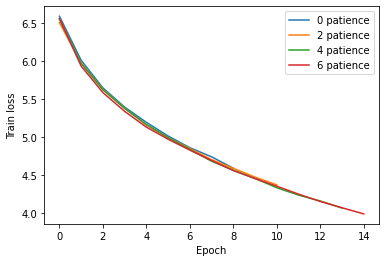

In [26]:
plt.plot(range(len(train_losses4)), train_losses1 + [None] * (len(train_losses4) - len(train_losses1)), label="0 patience")
plt.plot(range(len(train_losses4)), train_losses2 + [None] * (len(train_losses4) - len(train_losses2)), label="2 patience")
plt.plot(range(len(train_losses4)), train_losses3 + [None] * (len(train_losses4) - len(train_losses3)), label="4 patience")
plt.plot(range(len(train_losses4)), train_losses4 + [None] * (len(train_losses4) - len(train_losses4)), label="6 patience")
plt.legend(loc="upper right")
plt.ylabel("Train loss")
plt.xlabel("Epoch")
plt.savefig("./results/part2/images/train_loss")

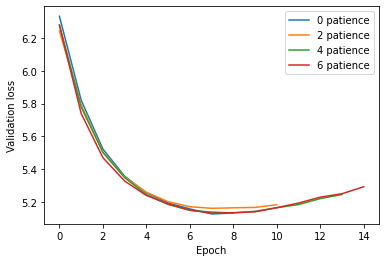

In [27]:
plt.plot(range(len(val_losses4)), val_losses1 + [None] * (len(val_losses4) - len(val_losses1)), label="0 patience")
plt.plot(range(len(val_losses4)), val_losses2 + [None] * (len(val_losses4) - len(val_losses2)), label="2 patience")
plt.plot(range(len(val_losses4)), val_losses3 + [None] * (len(val_losses4) - len(val_losses3)), label="4 patience")
plt.plot(range(len(val_losses4)), val_losses4 + [None] * (len(val_losses4) - len(val_losses4)), label="6 patience")
plt.legend(loc="upper right")
plt.ylabel("Validation loss")
plt.xlabel("Epoch")
plt.savefig("./results/part2/images/val_loss")

## 2 Learned embeddings (6 pts)

In [28]:
!pip install umap-learn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


In [29]:
%matplotlib inline 
import umap
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=1).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(10,10))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.show()

In [30]:
def get_best_model():
    best_model = None
    best_val_loss = math.inf
    l = os.listdir(os.path.join(PATH, "results", "part2", "models"))
    model_names = [d for d in l if not d.startswith('.')]
 
    for path in [os.path.join(PATH, "results", "part2", "models", name) for name in model_names]:

        if os.path.exists(path):
            checkpoint = torch.load(path)
            model = RNNLanguageModel(options).to(device)
            model.load_state_dict(checkpoint['model_state_dict'])
            val_loss = checkpoint.get('best_val_loss')

            if val_loss is not None and val_loss < best_val_loss:
                best_model = model
                print(path)

    # return best_model or RNNLanguageModel(options).to(device)
    return best_model

In [31]:
best_model = get_best_model()

./results/part2/models/max_patience_0.pt
./results/part2/models/max_patience_2.pt
./results/part2/models/max_patience_4.pt
./results/part2/models/max_patience_6.pt


In [32]:
print(best_model)

RNNLanguageModel(
  (lookup): Embedding(33181, 256, padding_idx=2)
  (rnn): LSTM(256, 512, num_layers=3, batch_first=True, dropout=0.3)
  (projection): Linear(in_features=512, out_features=33181, bias=True)
)


In [33]:
Vsize = len(wikitext_dict)                     # e.g. len(dictionary)
d = best_model.lookup.weight.size(1)           # e.g. model.lookup.weight.size(1) 
weight_matrix = best_model.projection.weight       # e.g. model.lookup.weight

In [34]:
def plot_words(words):
    word_ids = [wikitext_dict.get_id(word) for word in words]   # e.g. use dictionary.get_id on a list of words
    umap_plot(weight_matrix, word_ids, words)

#### 2.1 Word similarity (3 pts)


In [35]:
# from torch.nn.functional import cosine_similarity

def cosine_similarity(x1: torch.Tensor, x2: torch.Tensor) -> float:
    norm_x1 = torch.linalg.matrix_norm(x1).item()
    norm_x2 = torch.linalg.matrix_norm(x2).item()
    result = ((x1 * x2)/(norm_x1 * norm_x2)).sum()
    return result.item()


def distance(model, target_word: str):

    result = dict()

    with torch.no_grad():
        target_id = wikitext_dict.get_id(target_word)
        target_tensor = model.projection.weight[torch.tensor([target_id])]

        for source_word, id in wikitext_dict.ids.items():

            source_id = wikitext_dict.get_id(source_word)
            source_tensor = model.projection.weight[torch.tensor([source_id])]
            value = cosine_similarity(source_tensor, target_tensor)
            result[source_word] = value

        similar = dict(sorted(result.items(), key=lambda item: item[1], reverse=True)[:10])
        dissimilar = dict(sorted(result.items(), key=lambda item: item[1], reverse=True)[-10:])
    return list(similar.keys()), list(dissimilar.keys())


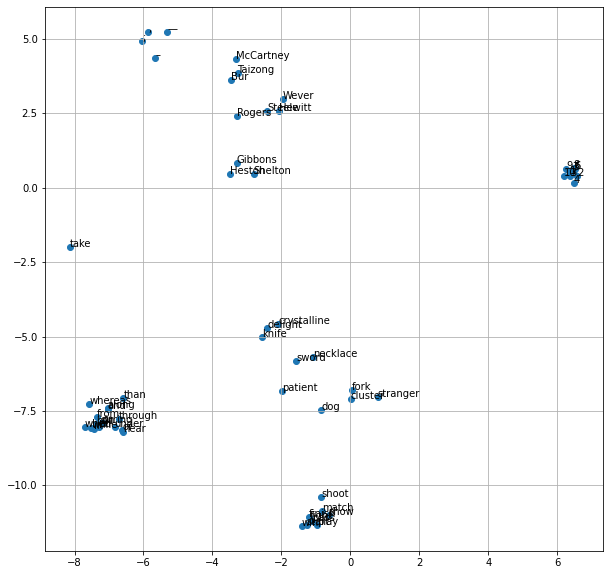

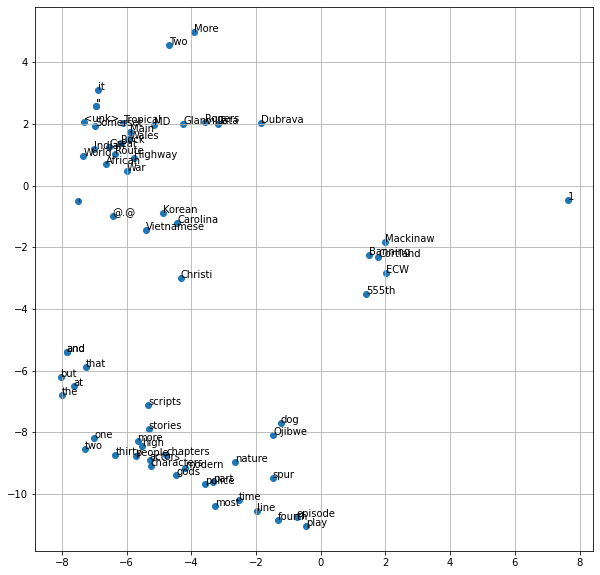

In [36]:
all_similar = list()
all_dissimilar = list()

for word in ["1", "dog", "at", "play", "Rogers", "and"]:
    similar, dissimilar  = distance(best_model, word)
    all_similar += similar
    all_dissimilar = all_dissimilar + dissimilar + [word]

plot_words(all_similar)
plot_words(all_dissimilar)

In [37]:
def sample(max_len = math.inf):

    sentence = ["<bos>", "the"]

    while sentence[-1] != "<eos>" and len(sentence) < max_len:
        ids = torch.tensor([wikitext_dict.get_id(word) for word in sentence])
        out_logits = best_model(ids.cuda())[-1]
        # print(out_logits.shape)
        probs = torch.nn.functional.softmax(out_logits, dim=0)
        next_index = torch.multinomial(probs, 1)
        next_word = wikitext_dict.get_token(next_index.item())
        sentence.append(next_word)
    return sentence

In [38]:
def get_log_probs(sentence):

    result_log = 0

    for i, word in enumerate(sentence[:-1], 1):
        prev_ids = torch.tensor([wikitext_dict.get_id(current_word) for current_word in sentence[:i]])
        with torch.no_grad():
            out_logits = best_model(prev_ids.cuda()).detach()
            probs = torch.nn.functional.softmax(out_logits, dim=0)[-1].squeeze()
            out = probs[wikitext_dict.get_id(word)]
            log_out = torch.log(out)
            result_log += log_out

    return result_log.item() / len(sentence[1:-1])

# sentence = ["<bos>", "play", "<eos>"]
# get_log_probs(sentence)

In [39]:
sample_sentences = list() 

for _ in tqdm(range(1000)):
    sentence = sample()
    sample_sentences.append(sentence)

100%|██████████| 1000/1000 [00:29<00:00, 34.35it/s]


In [40]:
sample_sentences

[['<bos>',
  'the',
  'athletes',
  'from',
  'each',
  'set',
  'like',
  'the',
  'philosophical',
  'faculty',
  'and',
  'passion',
  'recognised',
  'in',
  'combat',
  ',',
  'whose',
  'light',
  'rational',
  'ancestors',
  'are',
  'unknown',
  ',',
  'and',
  'are',
  'referred',
  'to',
  'materially',
  'through',
  'the',
  'interpretation',
  'of',
  'Legends',
  'that',
  'would',
  'be',
  'only',
  'Danish',
  '<unk>',
  'and',
  'peoples',
  'of',
  '<unk>',
  '.',
  '<eos>'],
 ['<bos>',
  'the',
  'moralitas',
  'that',
  'they',
  'had',
  'had',
  'to',
  'elevate',
  'the',
  'competition',
  'and',
  'again',
  'her',
  'worst',
  '.',
  '<eos>'],
 ['<bos>',
  'the',
  'assembly',
  'for',
  'still',
  'four',
  'men',
  'and',
  'depression',
  'acquired',
  'Georg',
  '6th',
  'Bank',
  "'s",
  'ocean',
  'lights',
  'listed',
  'the',
  'remains',
  'of',
  'the',
  'company',
  'during',
  'a',
  'raid',
  'and',
  'seventh',
  'Olympic',
  'aisle',
  'was',


In [2]:
log_prob = 0

for _sentence in sample_sentences:
    log_prob += get_log_probs(sentence)
avg_log_prob = log_prob / 1000
print(avg_log_prob)

-10.703


In [42]:
import random
val_sentences = [datasets['valid'][random.randint(0, len(datasets['valid']))] for _ in range(1000)]

In [43]:
def get_unique_tokens(sentences):
    result = set()
    for sentence in sentences:
        for token in sentence:
            result.add(token)
    return result

In [44]:
val_sentences_unique = get_unique_tokens(val_sentences)
sampled_sentences_unique = get_unique_tokens(sample_sentences)

In [45]:
len(sampled_sentences_unique)

5942

In [46]:
len(val_sentences_unique)

4856

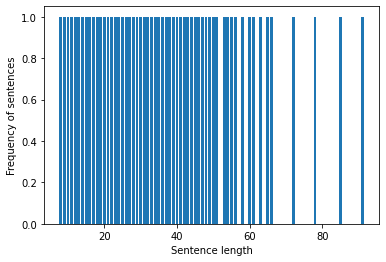

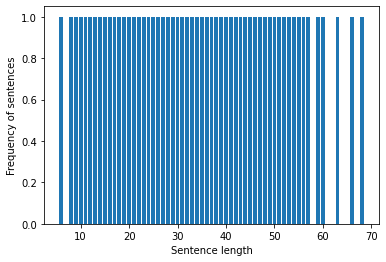

In [47]:
def get_lens(sentences):
    result = dict()
    for sentence in sentences:
        if len(sentence) in val_sentences:
            result[len(sentence)] += 1
        else:
            result[len(sentence)] = 1
    plt.bar(result.keys(), result.values())
    plt.xlabel("Sentence length")
    plt.ylabel("Frequency of sentences")
    plt.show()

get_lens(val_sentences)
get_lens(sample_sentences)


In [48]:
rand_ids = [random.randint(0, len(val_sentences)) for _ in range(3)]

def print_random(sentences, num_examples = 3):
    rand_ids = [random.randint(0, len(sentences)) for _ in range(num_examples)]
    for id in rand_ids:
        print(sentences[id])

print("\nValidation sentences\n")
print_random(val_sentences)

print("\nSampled sentences\n")
print_random(sample_sentences)


Validation sentences

['Two', 'new', 'main', 'floor', 'beams', 'for', 'the', 'dust', 'floor', 'were', 'made', 'from', '<unk>', 'of', 'pitch', 'pine', 'which', 'had', 'previously', 'been', 'in', 'a', '<unk>', 'at', 'Bury', 'St', '<unk>', '.']
['According', 'to', '<unk>', '<unk>', "'s", 'Lost', 'History', 'of', 'the', 'South', '(', '<unk>', '<unk>', ',', '<unk>', ')', ',', 'prior', 'to', 'the', 'Qing', 'invasion', 'of', '<unk']
['Since', 'then', 'a', 'detachment', 'of', 'Orion', 'maritime', 'patrol', 'aircraft', ',', 'support', 'personnel', ',', 'and', 'an', 'infantry', 'company', 'known', 'as', 'Rifle', 'Company', '<unk>', 'have', 'been', 'maintained', ',', 'as', 'well', 'as', 'occasional', 'deployments', 'of', 'F', '/', 'A', '@-@', '18', '<unk>', 'fighter', 'aircraft', '.']

Sampled sentences

['<bos>', 'the', 'field', 'and', 'both', 'started', 'it', 'in', 'Central', 'Africa', 'as', 'a', '11', '–', '8', 'season', '.', '<eos>']
['<bos>', 'the', 'final', 'promotion', 'of', 'the', 'secon

The sampled text can be perceived as machine generated due to the following reasons.
- Numbers and non alpha-numeric are present at unreasonable positions. For example '[' or '11' above.
- Segments of the sentence when read in isolation can be tricked to be human generated. For example, "the final promotion of the second season of his career". However, when the length of the sentence increases further, there seems to be a change in the topic.
- Apart for the above points, the grammar is good in a way that there are no abrupt combination of nouns, verbs, prepositions and articles.